In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import time
import msgpack
from torch_geometric.data import Data
import torch
from itertools import chain

In [7]:
base_folder = "../build"

In [13]:
done = 1
to_load = 16
def load_data_msgpack(filename):
    #global done
    c_data = {}
    with open(filename, 'rb') as f:
        data = msgpack.unpackb(f.read(), raw=False)
        for k_pixel in data.keys():
            h, w = list(map(int, k_pixel.split(',')))
            c_data[(h, w)] = data[k_pixel]['y']
    #done = done + 1
    return c_data

def load_and_convert(filename):
    #global done
    graphs = []
    with open(filename, 'rb') as f:
        data = msgpack.unpackb(f.read(), raw=False)
        
        # for each key data, extract graph
        for key, k_data in data.items():
            
            pixel = list(map(int, key.split(',')))
            
            # nodes data
            x_node = torch.tensor(k_data["x"], dtype=torch.float)
            x_node_pos = torch.tensor(k_data["pos"], dtype=torch.float)
            x_node_primary = torch.tensor(k_data["x_primary"], dtype=torch.bool)
            
            # edges data
            edge_index = torch.tensor(k_data["edge_index"], dtype=torch.long)    
            edge_attr = torch.tensor(k_data["edge_attr"], dtype=torch.float)
            edge_built = torch.tensor(k_data["edge_built"], dtype=torch.bool)
            
            # targets
            y_targets = torch.tensor(k_data["y"], dtype=torch.float)
            
            graph_data = Data(x=x_node, 
                            x_primary=x_node_primary, 
                            pos=x_node_pos,
                            edge_index=edge_index.t().contiguous(), 
                            edge_attr=edge_attr,
                            edge_built=edge_built, 
                            y=y_targets, 
                            key=pixel)
            graphs.append(graph_data)
    
    #output_dataset = os.path.join(output_folder, outfile.split('.')[0])
    #os.makedirs(output_dataset, exist_ok=True)
    return graphs

In [17]:
folder = os.path.join(base_folder, "output_gnn")
start = time.time()
all_graphs = [ load_and_convert(os.path.join(folder, j_f)) for j_f in os.listdir(folder) ]
end = time.time()
print(end - start)

8.014740467071533


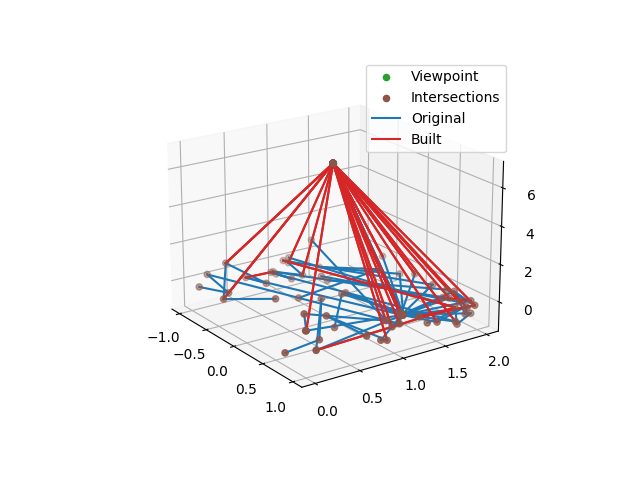

In [21]:
%matplotlib widget
  
# importing required libraries
import matplotlib.pyplot as plt
import numpy as np

ax = plt.figure().add_subplot(projection='3d')

def display_graph(ax, graph_data):

    pos_x, pos_y, pos_z = list(zip(*graph_data.pos))
    
    viewpoint_nodes = []
    intersections = []
    ax.scatter(pos_x[0], pos_y[0], pos_z[0], c='tab:green', label='Viewpoint')
    ax.scatter(pos_x[1:], pos_y[1:], pos_z[1:], c='tab:brown', label='Intersections')

    colors = ['tab:blue', 'tab:red']
    labels = ['Original', 'Built']
    labels_exist = [False, False]

    edge_index = np.array(graph_data.edge_index).T
    graph_data.pos = graph_data.x[:, 0:3]
    for c_i, (node_1, node_2) in enumerate(edge_index):
        pos = [graph_data.pos[node_1], graph_data.pos[node_2]]
        pos_x, pos_y, pos_z = list(zip(*pos))
        tag_index = graph_data.edge_built[c_i]

        line = ax.plot(pos_x, pos_y, pos_z, color=colors[tag_index])

        if not labels_exist[tag_index]:
            line[0].set_label(labels[tag_index])
            labels_exist[tag_index] = True
    
display_graph(ax, all_graphs[0][4])

ax.view_init(elev=20., azim=-35, roll=0)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ion()